Generate nutrient initial files to use in MITgcm runs from data.

Generate tracer initial conditions for MITgcm from Falkor and Line C data
=========================================================================

Profile interpolated from Pathways Curise 2013 at Barkley Canyon data nad Dave Capelle's methane and nitrous acid data from Line C May and September 2012 and 2013. You can also choose between data interp profile and linear interp.
K. Ramos-Musalem

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import seaborn as sns
import struct

In [15]:
sns.set_context('notebook')
sns.set_style('ticks')

In [13]:
def iniTracer(xsize, ysize, IniDepth, IniProfile, InterpDepth):
    
    InterpProfile = np.interp(InterpDepth, IniDepth , IniProfile)
    
    tracer = np.zeros((xsize, ysize, len(InterpDepth)))
    
    for ii in np.arange(xsize):
        
        for jj in np.arange(ysize):
            
            for kk in np.arange(len(InterpDepth)):
        
                tracer[ii,jj,kk]=InterpProfile[kk] 
            

    return tracer

In [8]:
def iniTracerLin(xsize, ysize, TopVal,BotVal, Depth ):
    
    # Generate linear nutrient profile (i.e. C(Depth)= IniVal*Depth) 
    
    M = (BotVal-TopVal)/(Depth[len(Depth)-1]-Depth[0])
    b = (TopVal - M*Depth[0])*np.ones((len(Depth),1))
    
    tracer = np.zeros((xsize, ysize, len(Depth)))
    
    for ii in np.arange(xsize):
        for jj in np.arange(ysize):
            for kk in np.arange(len(Depth)):
                tracer[ii,jj,kk]=M*Depth[kk]+b[kk] 
            

    return tracer

In [9]:
def iniTracerLinHor(xsize, zsize, TopVal,BotVal, yvec ):
    
    # Generate linear nutrient profile (i.e. C(yvec)= IniVal*yvec) 
    
    M = (BotVal-TopVal)/(yvec[len(yvec)-1]-yvec[0])
    b = (TopVal - M*yvec[0])*np.ones((len(yvec),1))
    
    tracer = np.zeros((xsize,len(yvec),zsize))
    
    for ii in np.arange(xsize):
        for jj in np.arange(zsize):
            for kk in np.arange(len(yvec)):
                tracer[ii,kk,jj]=M*yvec[kk]+b[kk] 
            

    return tracer

In [10]:
def iniTracerCnt(xsize, ysize, CntVal, Depth ):
    # Generate constant nutrient profile  
    
    tracer = np.ones((xsize, ysize, len(Depth)))
    tracer = tracer*CntVal
    

    return tracer

In [30]:
# Profile values form interp nutrient data from Falkor (see NutrientProfilesFalkor.ipynb)
dt = np.dtype('>f8')  # float 64 big endian
nx = 616
ny = 360
nz = 90

# Depth values
depth = [5.,20.,30.,50.,70.,100.,150.,170.,200.,300.,400.,500.,600.,700.,800.,1000.,1200.] #values form interp nutrient data 
                                                                                            # from Falkor (see NutrientProfilesFalkor.ipynb)
depthLineC = [0.,50.,100.,150.,200.,250.,300.,350.,400.,450.,500.,550.,600.,650.,700.,750.]

depthDIC = [10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 70.0, 85.0, 100.0, 125.0, 
            150.0, 160.0, 170.0, 185.0, 325.0, 350.0, 400.0, 425.0, 
            450.0, 500.0, 550.0, 600.0, 700.0, 800.0, 1000.0, 1200.0] 
# I had to use more levels to interpolate DIC because there are lots of NaNs

#Model depth levels

#zi = (5,10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,105,
#      110,115,120,125,130,135,140,145,150,155,160,165,170,180,190,200,210,220,230,240,250,
#      260,280,300,320,340,360,380,400,420,440,460,480,500,520,540,560,580,600,620,640,660,
#      680,700,720,740,760,780,800,820,840,860,880,900,920,940,960,980,1000,1020,1040,1060,
#      1080,1100,1120,1140,1160,1180,1200) # Original depth levels, delete soon

zi = (5,10,15,20,25,30,35,40,45,50,
      55,60,65,70,75,80,85,90,95,100,
      105,110,115,120,125,130,135,140,145,150,
      155,160,165,170,175,180,185,190,195,200,
      205,210,215,220,225,230,235,240,245,250,
      255,260,270,280,300,320,340,360,380,400,
      420,440,460,480,500,520,540,560,580,600,
      620,640,660,680,700,720,740,760,780,800,
      840,880,920,960,1000,1040,1080,1120,1160,1200) # 5m resolution top 260m

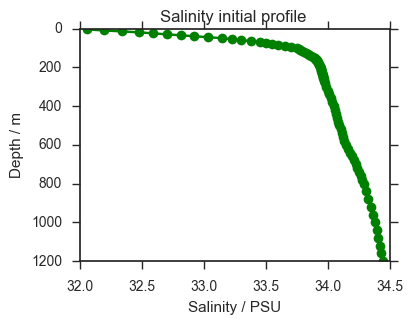

In [18]:
#Salinity

sal = [32.05565615,  32.47904982,  32.69883153,  33.14754095,
        33.45287546,  33.74755425,  33.89389881,  33.9139597 ,
        33.93728968,  33.98439263,  34.04611345,  34.09233602,
        34.14232788,  34.22413622,  34.28826251,  34.37998532,  34.4410795 ] #Falkor Salinity

Sal = iniTracer(nx,ny,depth,sal,zi)

# Save binary file
tmpfile = "%dx%dx%d/Barkley_sal_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Sal2 = Sal.transpose((2,0,1)) # To keep fortran order when writing as C binarynp.asfortranarray(Sal)
Sal2.astype(dt).tofile(fileobj,"")
fileobj.close()


# PLOT
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(Sal[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Salinity / PSS-78')
plt.ylabel('Depth / m')
plt.title('Salinity initial profile ')


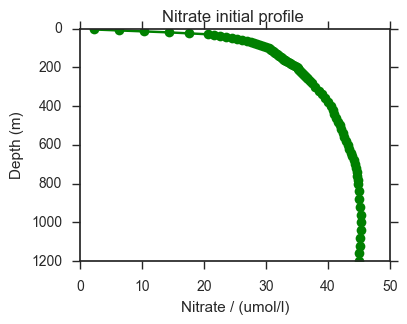

In [20]:
#Nitrate

nit = [  2.20769231,  14.30606356,  20.69884474,  24.54682499,
        27.64221491,  30.40401935,  32.60791595,  33.23055095,
        34.93009381,  37.96639598,  40.48248953,  41.87936656,
        43.16092676,  44.42630919,  44.86319564,  45.33917039,  45.01343725] #Falkor Nitrate, umol/L

Nitrate = iniTracer(nx,ny,depth,nit,zi)
               
# Save binary file
tmpfile = "%dx%dx%d/Barkley_nit_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Nitrate2 = Nitrate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Nitrate2.astype(dt).tofile(fileobj,"")
fileobj.close()


# Plot
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(Nitrate[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Nitrate / $\mu$M')
plt.ylabel('Depth (m)')
plt.title('Nitrate initial profile ')


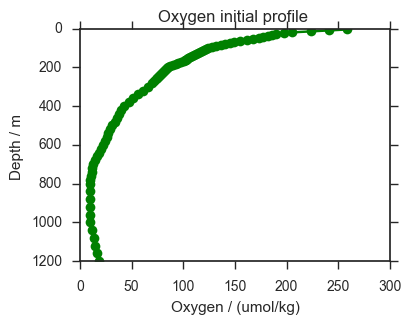

In [21]:
# Oxygen

oxy = [ 258.64692308,  205.30523866,  189.93474682,  173.32762752,
        148.99494704,  123.39376698,  104.07073273,  100.34682448,
         84.75278265,   65.32870403,   42.38594405,   31.24731648,
         22.04183918,   12.32014822,    9.56728914,   10.02871031,
         18.18188635] #Falkor Oxygen, umol/kg

Oxygen = iniTracer(nx,ny,depth,oxy,zi)

# Save binary file
tmpfile = "%dx%dx%d/Barkley_oxy_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Oxygen2 = Oxygen.transpose((2,0,1)) # To keep fortran order when writing as C binary
Oxygen2.astype(dt).tofile(fileobj,"")
fileobj.close()        

### PLOT Contour

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(Oxygen[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Oxygen / (umol/kg)')
plt.ylabel('Depth / m ')
plt.title('Oxygen initial profile ')

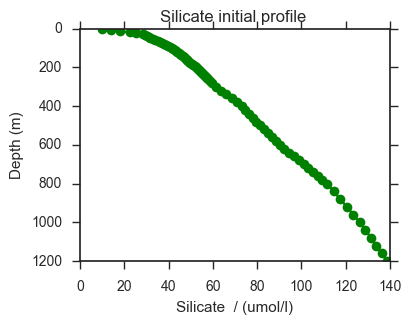

In [22]:
# Silicate
sil = [ 9.77487179,   22.40324386,   28.481157  ,   31.81179168,
         36.35084393,   41.51053289,   47.62601443,   48.57082304,
         52.54408413,   61.52273871,   73.08433615,   81.12181574,
         90.16770523,  101.05308596,  111.55221474,  126.39029233,
        138.72363852 ] #Falkor Silicate

Silicate = iniTracer(nx,ny,depth,sil,zi)

# Save binary file
tmpfile = "%dx%dx%d/Barkley_sil_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Silicate2 = Silicate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Silicate2.astype(dt).tofile(fileobj,"")
fileobj.close()              

# Plot

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(Silicate[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Silicate  / $\mu$M')    
plt.ylabel('Depth (m)')
plt.title('Silicate initial profile ')

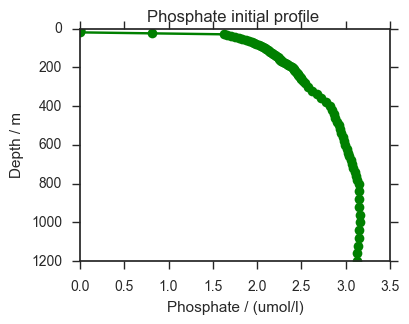

In [23]:
# Phosphate

pho = [0, 0,  1.6205616 ,  1.79738767,  1.94555393,
       2.08709737,  2.24576282,  2.27144092,  2.39342327,  2.57196961,
       2.82463189,  2.92081108,  2.99713342,  3.06841061,  3.14757836,
       3.16063801,  3.12403118  ] #Falkor Phosphate

Phosphate = iniTracer(nx,ny,depth,pho,zi)
              
# Save binary file
tmpfile = "%dx%dx%d/Barkley_pho_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Phosphate2 = Phosphate.transpose((2,0,1)) # To keep fortran order when writing as C binary
Phosphate2.astype(dt).tofile(fileobj,"")
fileobj.close()              

# Plot 
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(Phosphate[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Phosphate / $\mu$M$')
plt.ylabel('Depth / m')
plt.title('Phosphate initial profile ')

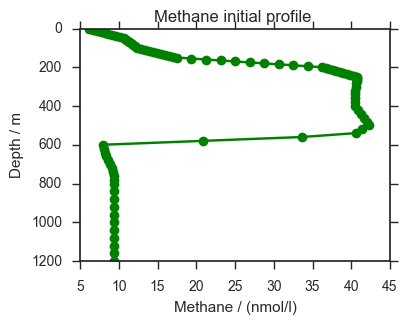

In [24]:
# Methane

met = [ 5.7       ,  10.64469773,  12.39183632,  17.50460996,
        36.27632856,  40.79841802,  40.55482783,  40.51003523,
        40.46664286,  41.40465804,  42.34615163,  40.09929176,
        7.96460677,   8.29779559,   8.8488978 ,   9.4  ] # LineC Methane

Methane = iniTracer(nx,ny,depthLineC,met,zi)
             
# Save binary file
tmpfile = "%dx%dx%d/LineCSep2013_met_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
Methane2 = Methane.transpose((2,0,1)) # To keep fortran order when writing as C binary
Methane2.astype(dt).tofile(fileobj,"")
fileobj.close()              

# Plot

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(Methane[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Methane / nM')    
plt.ylabel('Depth / m')
plt.title('Methane initial profile ')

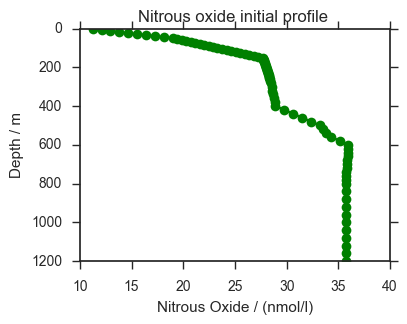

In [25]:
# Nitrous Oxide

nox = [  10.35      ,  19.00521367,  23.30548951,  27.66736277,
        28.00249004,  28.3022331 ,  28.55923913,  28.73341284,
        28.91225443,  31.05146831,  33.1970117 ,  33.93446295,
        35.92803017,  35.91032064,  35.83016032,  35.75  ] # LineC Methane

NitOx = iniTracer(nx,ny,depthLineC,nox,zi)
         
# Save binary file
tmpfile = "%dx%dx%d/LineCSep2013_nox_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
NitOx2 = NitOx.transpose((2,0,1)) # To keep fortran order when writing as C binary
NitOx2.astype(dt).tofile(fileobj,"")
fileobj.close()              

# Plot 
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(NitOx[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('Nitrous Oxide / nM')
plt.ylabel('Depth / m')
plt.title('Nitrous oxide initial profile ')

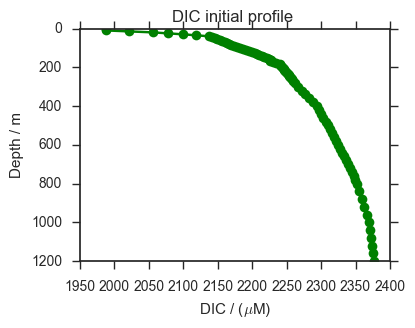

In [33]:
# DIC

dic = [1988.137, 2020.864, 2055.613, 2077.559, 2099.430, 2136.736, 2145.807,
       2160.378,  2169.597,  2182.130,  2203.547,    2220.859,
       2226.993,   2225.535,  2239.758,   2272.775,  2279.751,  2293.704,
       2298.125,  2301.907 ,   2309.473,  2317.095,  2324.727,
       2339.422,  2352.259,  2369.299,  2376.510] # Falkor DIC, bottle measurements, interp from salinity

DIC = iniTracer(nx,ny,depthDIC,dic,zi)
         
# Save binary file
tmpfile = "%dx%dx%d/Barkley_DIC_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
DIC2 = DIC.transpose((2,0,1)) # To keep fortran order when writing as C binary
DIC2.astype(dt).tofile(fileobj,"")
fileobj.close()              

# Plot 
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(DIC[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('DIC / $\mu$M')
plt.ylabel('Depth / m')
plt.title('DIC initial profile ')

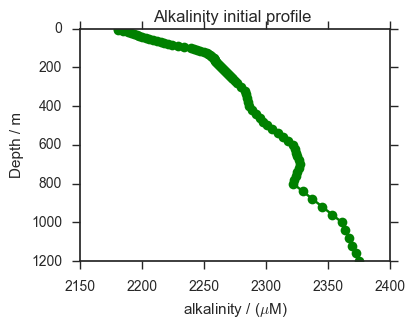

In [34]:
# Alkalinity

alk = [2180.908,  2184.611,  2188.541,  2191.024,   2193.498,  2197.718,  2202.834,
       2214.932,  2224.044,  2239.146,  2252.351,   2257.815,  2258.880,  2258.627,  
       2260.944,  2283.506,  2284.351,  2286.042,   2289.345,  2293.262,  2301.098, 
       2311.357,  2322.016,  2327.346,  2321.732,   2361.124,  2375.323] 
# Falkor Alkalinity, bottle measurements, interp from salinity

alkalinity = iniTracer(nx,ny,depthDIC,alk,zi)
         
# Save binary file
tmpfile = "%dx%dx%d/Barkley_Alk_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
fileobj = open(tmpfile,mode='wb')
alkalinity2 = alkalinity.transpose((2,0,1)) # To keep fortran order when writing as C binary
alkalinity2.astype(dt).tofile(fileobj,"")
fileobj.close()              

# Plot 
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(np.squeeze(alkalinity[60,45,:]),zi,'go-')
ax.invert_yaxis()
plt.xlabel('alkalinity / $\mu$M')
plt.ylabel('Depth / m')
plt.title('Alkalinity initial profile ')

Let's check what we wrote...

In [36]:
fileNAME = "%dx%dx%d/LineCSep2013_nox_%dzlev_newRes_%dx%d.bin" %(nx,ny,nz,nz,nx,ny)
tempp=np.fromfile(fileNAME, dt)

In [37]:
temppp=np.reshape(tempp,(nx,ny,len(zi)),order='F')
np.shape(temppp)

(616, 360, 90)

In [38]:
print(max(tempp))

35.92803017


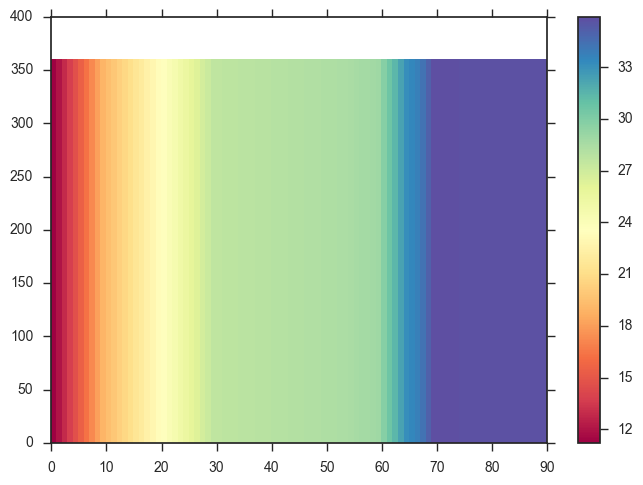

In [39]:
plt.pcolor(temppp[80,:,:], cmap='Spectral')
plt.colorbar()